In [1]:
# prerequisites 
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import pandas as pd

/tmp/ipykernel_12237/1339951104.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def readDatas(dataPath: str):
    return pd.read_csv(dataPath,delimiter=',', header='infer')

In [3]:
def plotDataDistribution(df_world_happiness):
    fig,axes = plt.subplots(nrows=3,figsize=(15,15))

    axes[0].hist(df_world_happiness["Happiness.Score"])
    axes[0].set_title("Happiness")

    axes[1].hist(df_world_happiness["Economy..GDP.per.Capita."])
    axes[1].set_title("PIB")

    axes[2].hist(df_world_happiness["Freedom"])
    axes[2].set_title("Freedom")
    plt.show()

In [4]:
def plotData(df_world_happiness):
    axes  = plt.figure().add_subplot(projection='3d')

    axes.scatter(df_world_happiness["Economy..GDP.per.Capita."],df_world_happiness["Freedom"],df_world_happiness["Happiness.Score"])
    axes.set_xlabel('GDP')
    axes.set_ylabel('Happiness')
    axes.set_zlabel('Freedom')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

In [5]:
def getTrainingAndValidationSets(df_world_happiness):
    dataSize = df_world_happiness.shape[0]
    trainingIndexSet = np.random.choice(range(dataSize),size=int(0.8 * dataSize),replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet] 

    trainingInputSet = [(df_world_happiness["Economy..GDP.per.Capita."].iloc[index],df_world_happiness["Freedom"].iloc[index]) for index in trainingIndexSet ]
    trainingOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in trainingIndexSet ]

    validationInputSet = [(df_world_happiness["Economy..GDP.per.Capita."].iloc[index],df_world_happiness["Freedom"].iloc[index]) for index in validationIndexSet ]
    validationOutputSet = [df_world_happiness["Happiness.Score"].iloc[index] for index in validationIndexSet ]
    
    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet

def plotTrainingAndValidationDatas(df_world_happiness):
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    axes  = plt.figure().add_subplot(projection='3d')

    xTraining = [point[0] for point in trainingInputSet]
    yTraining = [point[1] for point in trainingInputSet]

    xValidation = [point[0] for point in validationInputSet]
    yValidation = [point[1] for point in validationInputSet]

    axes.scatter(xTraining,yTraining,trainingOutputSet)
    axes.scatter(xValidation,yValidation,validationOutputSet)
    axes.set_xlabel('GDP')
    axes.set_ylabel('Happiness')
    axes.set_zlabel('Freedom')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

In [6]:
def getRegressor(df_world_happiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(df_world_happiness)
    xx = [el for el in trainingInputSet]

    regressor = linear_model.LinearRegression()
    regressor.fit(xx, trainingOutputSet)

    return regressor

In [7]:
def plotRegressor(df_world_happiness):

    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(df_world_happiness)
    regressor = getRegressor(df_world_happiness)
    w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]
    noOfPoints = 1000
    xref = []
    gdp = [point[0] for point in trainingInputSet]
    freedom = [point[1] for point in trainingInputSet]
    valGDP = min(gdp)
    valFreedom = min(freedom)
    stepGDP = (max(gdp) - min(gdp)) / noOfPoints
    stepFreedom = (max(freedom) - min(freedom)) / noOfPoints
    for _ in range(1, noOfPoints):
        xref.append((valGDP,valFreedom))
        valGDP += stepGDP
        valFreedom += stepFreedom
    yref = [w0 + w1 * el[0] + w2 * el[1] for el in xref] 

    axes  = plt.figure().add_subplot(projection='3d')

    axes.scatter(gdp,freedom,trainingOutputSet)
    axes.plot([x[0] for x in xref],[x[1] for x in xref], yref,'red')                  #model is plotted by a blue line
    axes.set_title('train data and the learnt model')
    axes.set_xlabel('GDP')
    axes.set_ylabel('happiness')
    plt.show()


In [8]:
from sklearn.metrics import mean_squared_error

def getErrors(df_world_happiness):
    _,_,validationInputSet, validationOutputSet = getTrainingAndValidationSets(df_world_happiness)
    regressor = getRegressor(df_world_happiness)
    computedValidationOutputs = regressor.predict([x for x in validationInputSet])
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputSet):
        manualError += (t1 - t2) ** 2
    manualError = manualError / len(validationOutputSet)
    computedError = mean_squared_error(validationOutputSet, computedValidationOutputs)
    return manualError, computedError


## Problema 1

In [9]:
world_happiness = readDatas("datas/v1_world-happiness-report-2017.csv")
world_happiness = world_happiness.dropna()

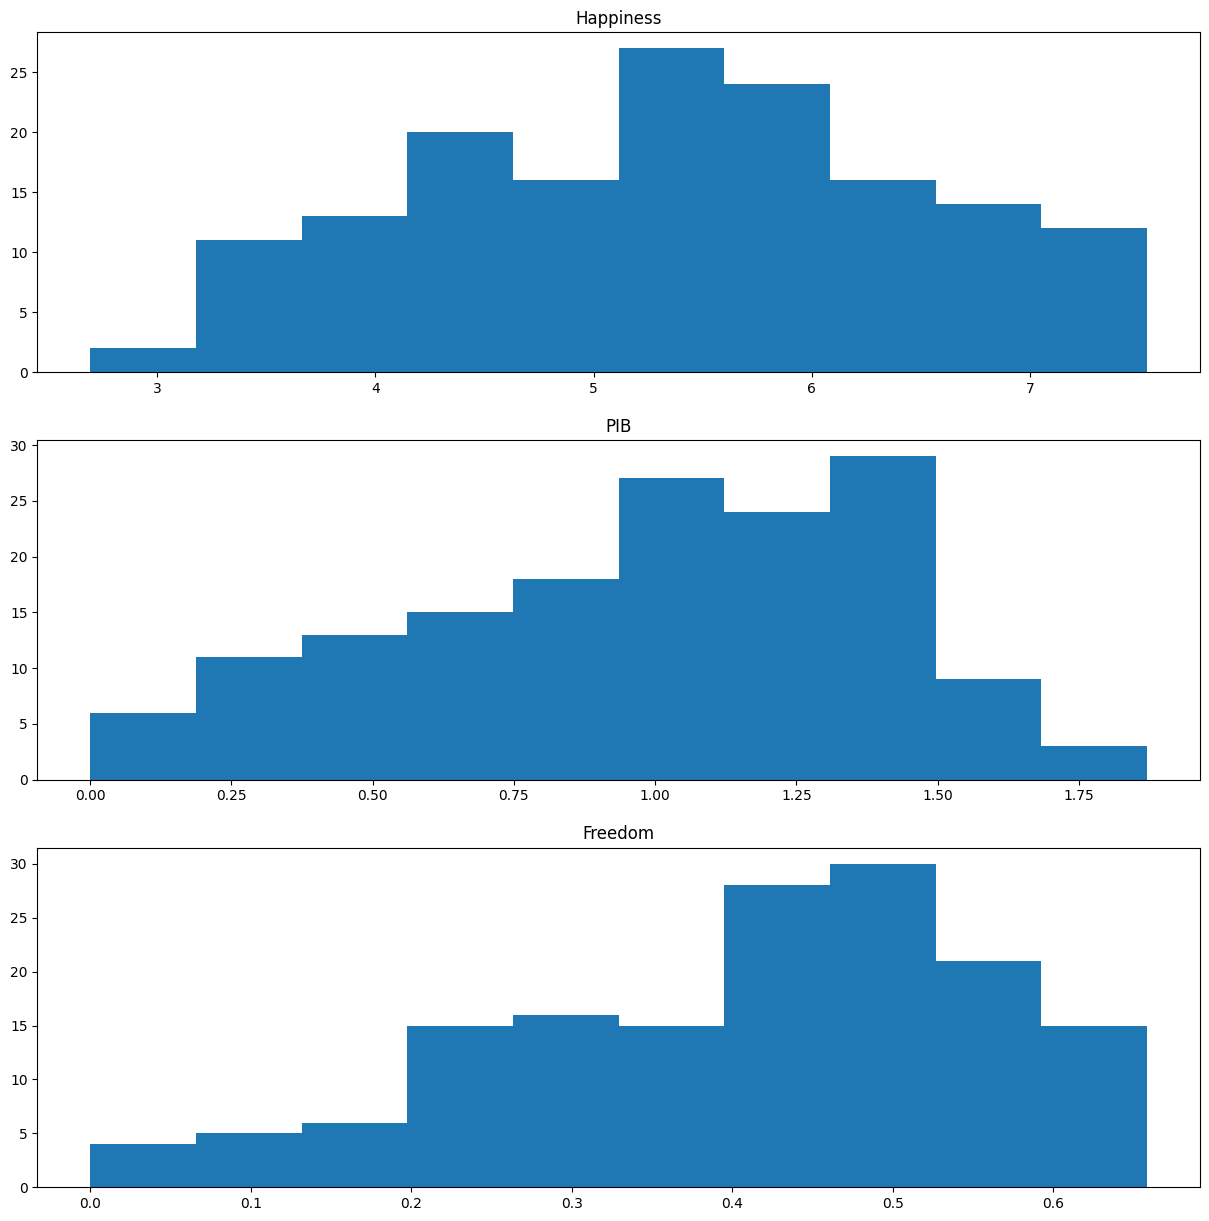

In [10]:
plotDataDistribution(world_happiness)

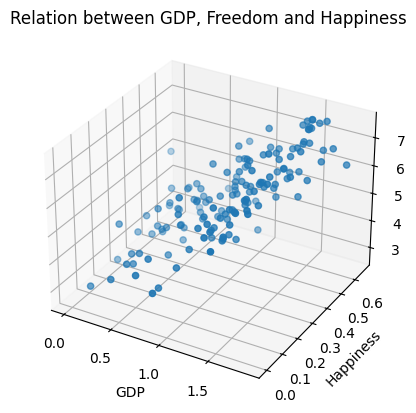

In [11]:
plotData(world_happiness)

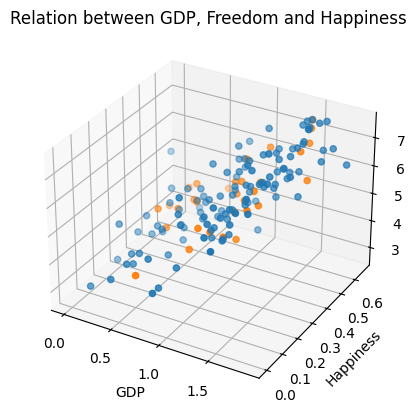

In [12]:
plotTrainingAndValidationDatas(world_happiness)

In [13]:
regresor = getRegressor(world_happiness)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 2.506779333718851 + 1.942871214610008*x1 + 2.2444076835006452*x2


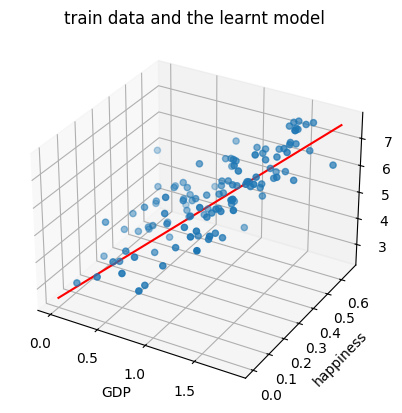

In [14]:
plotRegressor(world_happiness)

In [15]:
mErr, cErr = getErrors(world_happiness)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.3211794294578713
Computed error: 0.32117942945787126


## Problema 2

In [16]:
world_happiness = readDatas("datas/v2_world-happiness-report-2017.csv")
world_happiness = world_happiness.dropna()

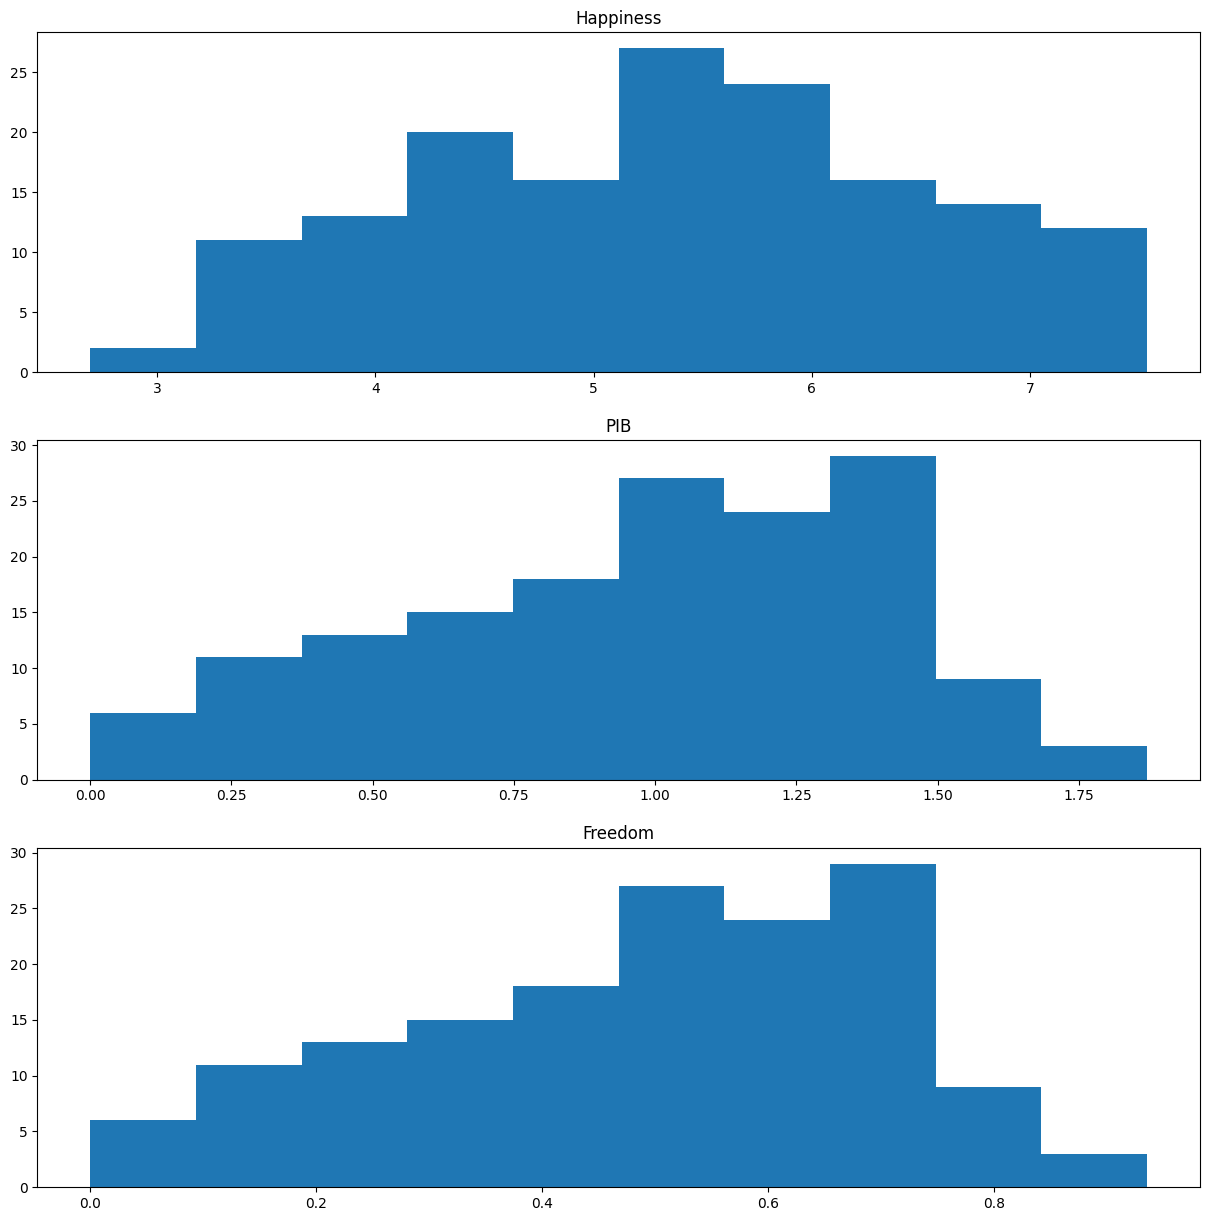

In [17]:
plotDataDistribution(world_happiness)

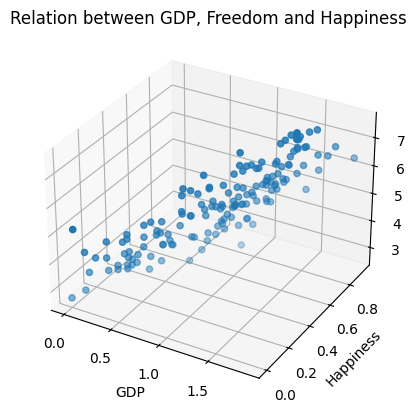

In [18]:
plotData(world_happiness)

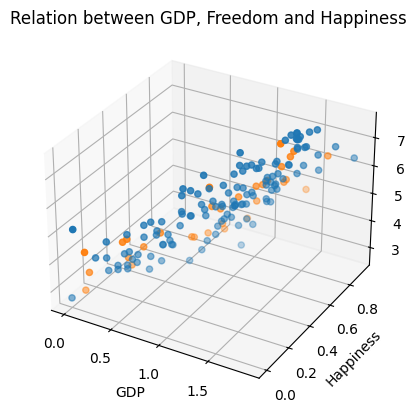

In [19]:
plotTrainingAndValidationDatas(world_happiness)

In [20]:
regresor = getRegressor(world_happiness)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 3.3108488378937793 + 47167214.42666831*x1 + -94334424.73007266*x2


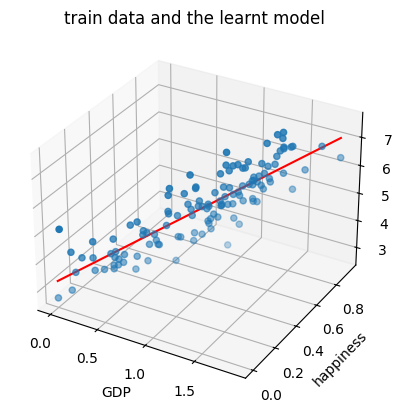

In [21]:
plotRegressor(world_happiness)

In [22]:
mErr, cErr = getErrors(world_happiness)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.41591613065228555
Computed error: 0.4159161306522855


## Problema 3

In [23]:
world_happiness = readDatas("datas/v2_world-happiness-report-2017.csv")
world_happiness = world_happiness.dropna()

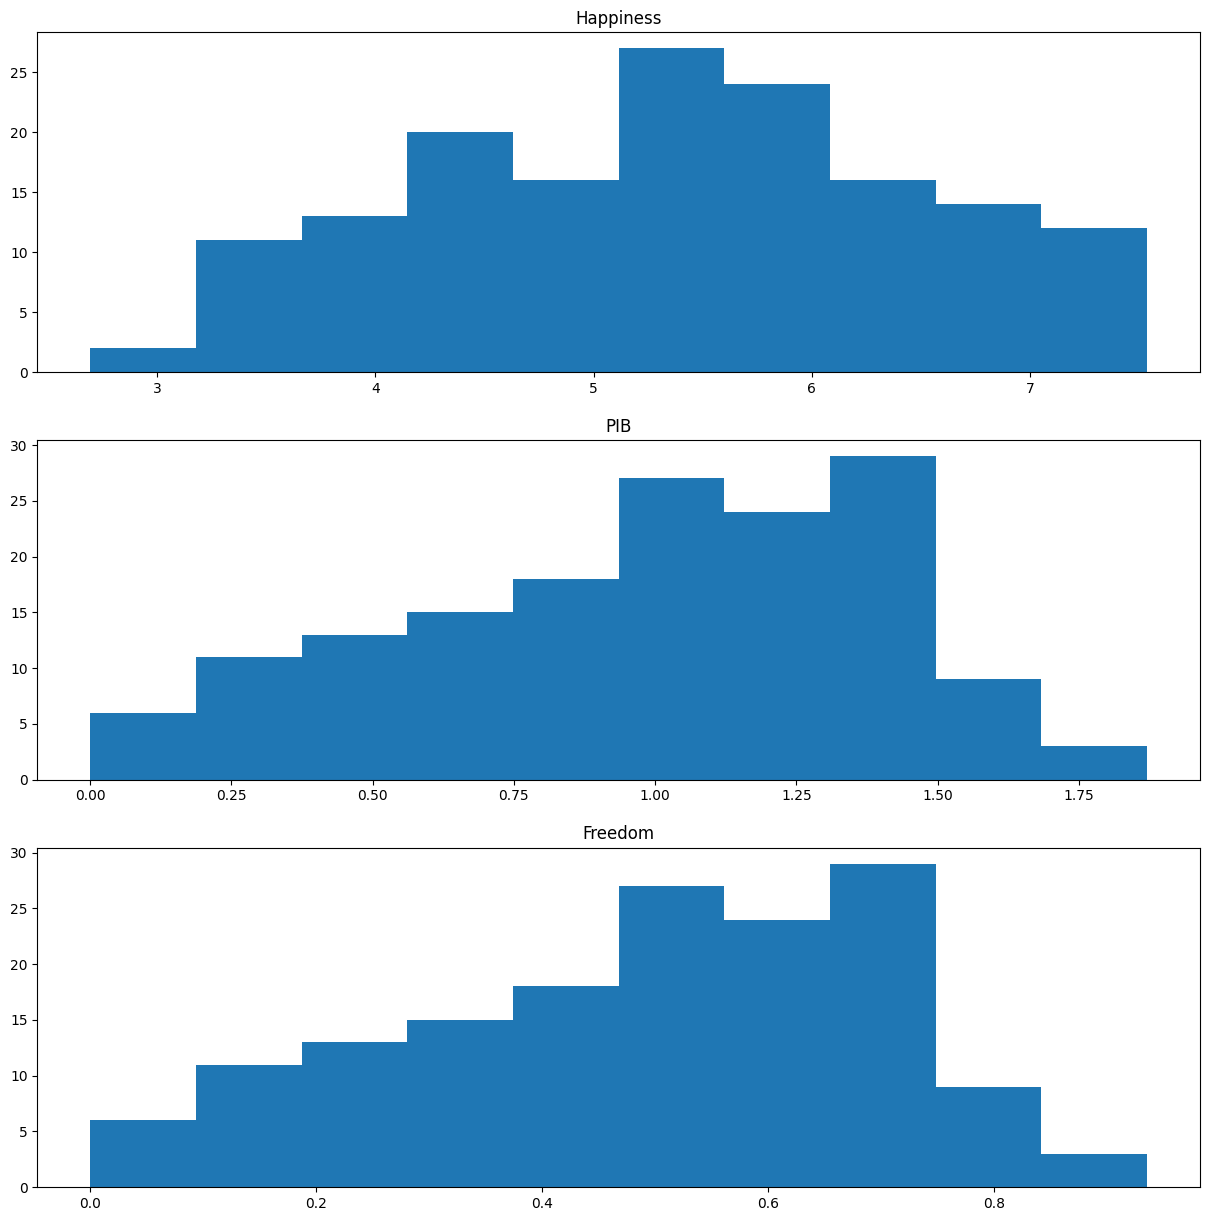

In [24]:
plotDataDistribution(world_happiness)

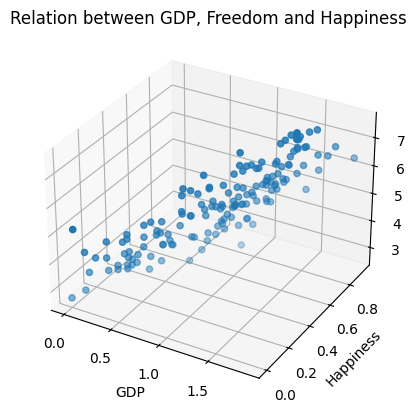

In [25]:
plotData(world_happiness)

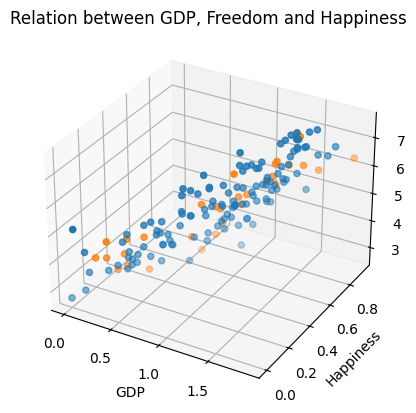

In [26]:
plotTrainingAndValidationDatas(world_happiness)

In [27]:
regresor = getRegressor(world_happiness)
w0, w1, w2 = regresor.intercept_, regresor.coef_[0], regresor.coef_[1]

print("f(x) = {} + {}*x1 + {}*x2".format(w0,w1,w2))

f(x) = 3.2398420137289135 + -39490045.04064592*x1 + 78980094.35142389*x2


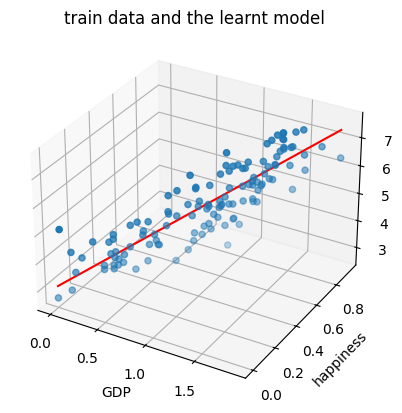

In [28]:
plotRegressor(world_happiness)

In [29]:
mErr, cErr = getErrors(world_happiness)

print("Manual error: {}\nComputed error: {}".format(mErr,cErr))

Manual error: 0.2236955201279785
Computed error: 0.22369552012797855
